In [21]:
from keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import numpy as np
import seaborn as sns
print(tf.__version__)
print(l2)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam



2.16.1
<class 'keras.src.regularizers.regularizers.L2'>


In [22]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    images = []
    labels_list = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img_arr is None:
                    print(f"Error loading image: {img_path}")
                    continue  # Skip this image
                
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
                images.append(resized_arr)
                labels_list.append(class_num)
            except Exception as e:
                print(f"Exception while processing image {img}: {e}")
    
    # Convert lists to NumPy arrays
    images = np.array(images)
    labels_list = np.array(labels_list)
    
    return images, labels_list

In [23]:
# Load the training, testing, and validation datasets
train = get_training_data('/kaggle/input/dataset1/train')
test = get_training_data('/kaggle/input/dataset1/test')
val = get_training_data('/kaggle/input/dataset1/val')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


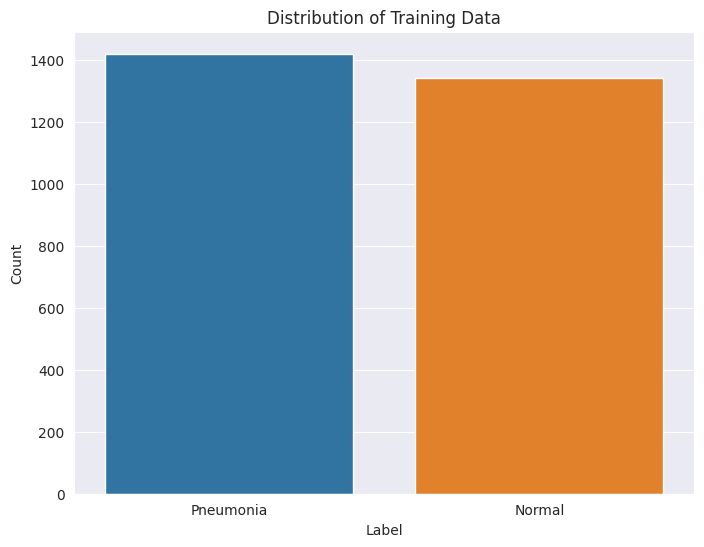

In [24]:
train_images, train_labels = train
train_images, train_labels = train

# Map the labels to "Pneumonia" and "Normal" for visualization
label_names = ['Pneumonia' if label == 0 else 'Normal' for label in train_labels]

# Visualize the data
sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))
sns.countplot(x=label_names)
plt.title('Distribution of Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
#plt.xticks(rotation=45)
plt.show()

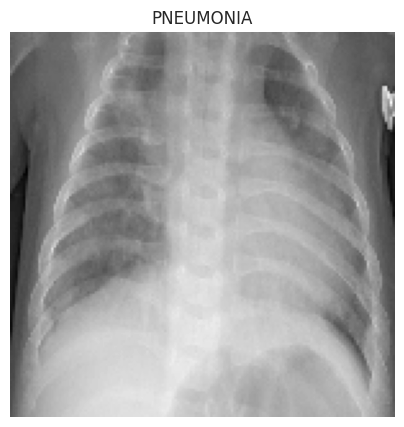

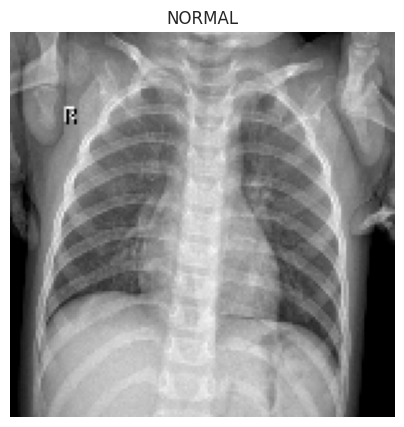

In [25]:
# Display the first image
plt.figure(figsize=(5, 5))
plt.imshow(train_images[0], cmap='gray')  # Accessing the first image
plt.title(labels[train_labels[0]])  # Accessing the corresponding label
plt.axis('off')  # Turn off axis labels
plt.show()

# Display the last image
plt.figure(figsize=(5, 5))
plt.imshow(train_images[-1], cmap='gray')  # Accessing the last image
plt.title(labels[train_labels[-1]])  # Accessing the corresponding label
plt.axis('off')  # Turn off axis labels
plt.show()

In [26]:
# Unpacking the images and labels from the datasets
x_train, y_train = train  # Unpack training data
x_test, y_test = test     # Unpack testing data
x_val, y_val = val        # Unpack validation data

# Optionally, you can convert the lists to numpy arrays if needed
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

# Verify the shapes of the datasets
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


x_train shape: (2762, 150, 150), y_train shape: (2762,)
x_val shape: (16, 150, 150), y_val shape: (16,)
x_test shape: (624, 150, 150), y_test shape: (624,)


In [27]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [28]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [29]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        # rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        vertical_flip=False)  # randomly flip images
# datagen = ImageDataGenerator(
#     rescale=1./255,            # Normalize pixel values to [0, 1]
#     rotation_range=20,         # Rotate images by up to 20 degrees
#     width_shift_range=0.2,     # Shift images horizontally by 20% of width
#     height_shift_range=0.2,    # Shift images vertically by 20% of height
#     shear_range=0.2,           # Shear transformations
#     zoom_range=0.2,            # Random zoom
#     horizontal_flip=True,      # Randomly flip images horizontally
#     vertical_flip=False,       # Disable vertical flips (not helpful for most cases)
#     fill_mode='nearest'        # Fill missing pixels after transformation
# )

datagen.fit(x_train)

In [30]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(units = 1 , activation = 'sigmoid'))


model.compile(optimizer = Adam(learning_rate=0.001) , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,769,409 (6.75 MB)

 Trainable params: 1,768,833 (6.75 MB)

 Non-trainable params: 576 (2.25 KB)

In [31]:
# Updated callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.000001)

In [32]:
# Define the ModelCheckpoint callback with .keras extension
checkpoint = ModelCheckpoint(
    'best_model1.keras',          # Path to save the model with .keras extension
    monitor='val_loss',            # Metric to monitor, could also be 'val_accuracy'
    mode='min',                    # 'min' for loss, 'max' for accuracy
    save_best_only=True,           # Save only the best model
    verbose=1                      # Print a message when a model checkpoint is saved
)

# Train the model with the updated checkpoint callback
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=30,
    validation_data=datagen.flow(x_val, y_val),
    callbacks=[checkpoint, early_stopping, learning_rate_reduction]
)
from tensorflow.keras.models import load_model

# Load the saved .keras model
best_model = load_model('best_model1.keras')

# Save the loaded model in .h5 format
best_model.save('chest_xray.h5')
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']



Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.7099 - loss: 4.9033
Epoch 1: val_loss improved from inf to 15.15586, saving model to best_model1.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - accuracy: 0.7144 - loss: 4.8283 - val_accuracy: 0.5000 - val_loss: 15.1559 - learning_rate: 0.0010
Epoch 2/30
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9375 - loss: 1.7343
Epoch 2: val_loss improved from 15.15586 to 14.82779, saving model to best_model1.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9374 - loss: 1.7277 - val_accuracy: 0.5000 - val_loss: 14.8278 - learning_rate: 0.0010
Epoch 3/30
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9436 - loss: 1.1620
Epoch 3: val_loss improved from 14.82779 to 10.72137, saving model to best_model1.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9437 - loss: 1.1577 - val_accuracy: 0.5000 - val_loss: 10.7214 - learning_rate: 0.0010
Epoch 4/30
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9502 -

In [33]:
# Get the highest validation accuracy and corresponding validation loss from training history
best_val_accuracy = max(history.history['val_accuracy'])
best_val_loss_index = history.history['val_accuracy'].index(best_val_accuracy)
best_val_loss = history.history['val_loss'][best_val_loss_index]

print(f"Highest Validation Accuracy: {best_val_accuracy * 100:.2f}%")
print(f"Validation Loss at Highest Accuracy: {best_val_loss:.4f}")


# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Highest Validation Accuracy: 93.75%
Validation Loss at Highest Accuracy: 0.4273
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9230 - loss: 0.3288
Test Loss: 0.8888
Test Accuracy: 76.12%


In [34]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9230 - loss: 0.3288
Loss of the model is -  0.8887652158737183
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9230 - loss: 0.3288
Accuracy of the model is -  76.12179517745972 %


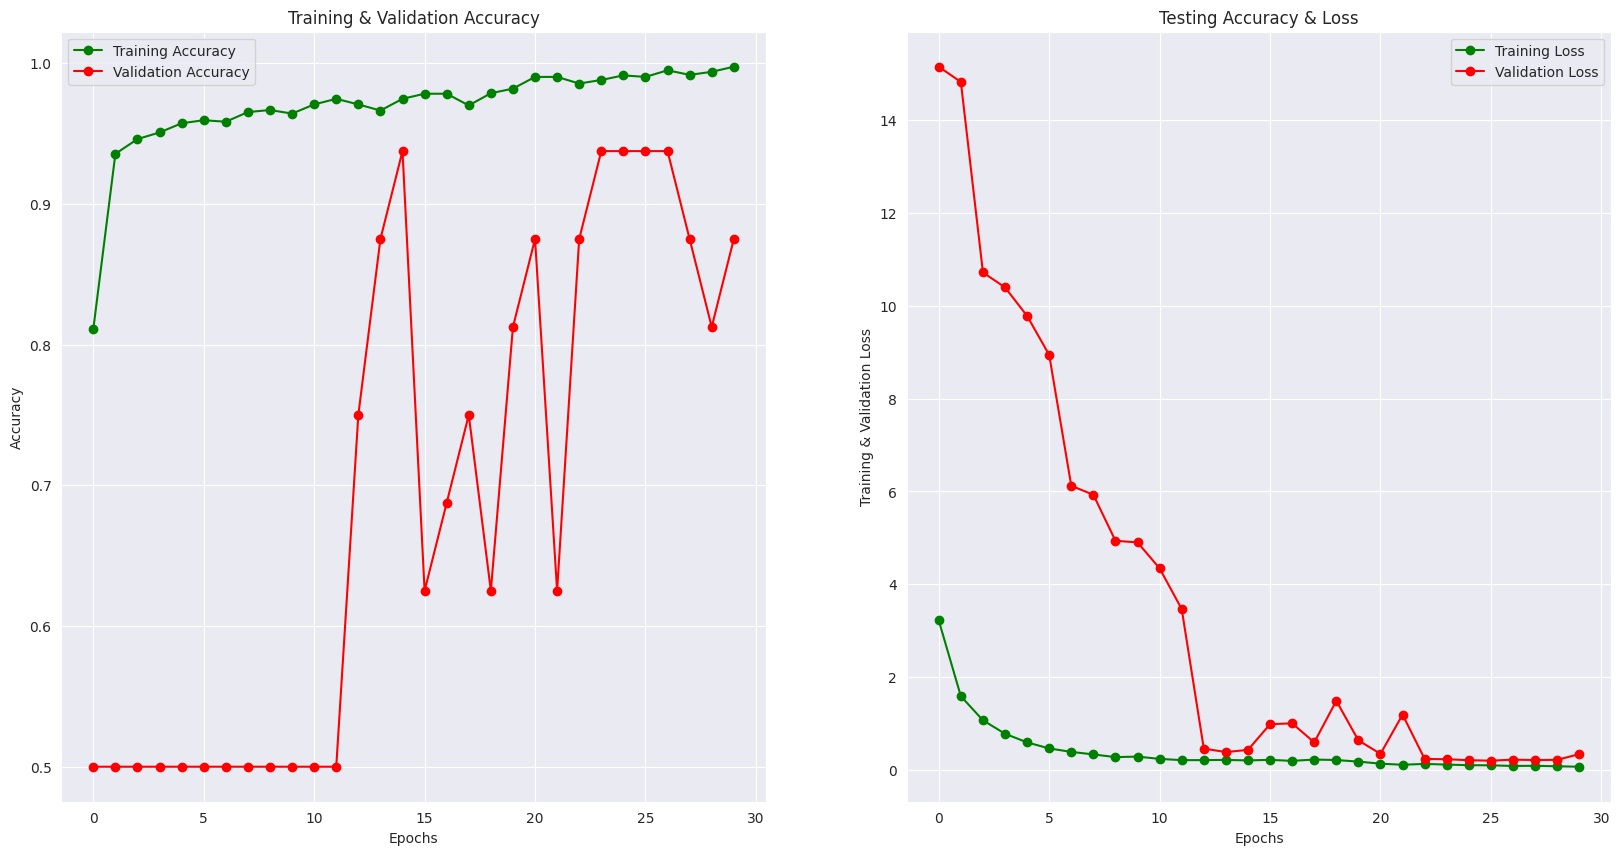

In [35]:
# epochs = [i for i in range(12)]
# fig , ax = plt.subplots(1,2)
# train_acc = history.history['accuracy']
# train_loss = history.history['loss']
# val_acc = history.history['val_accuracy']
# val_loss = history.history['val_loss']
# fig.set_size_inches(20,10)

# ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
# ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
# ax[0].set_title('Training & Validation Accuracy')
# ax[0].legend()
# ax[0].set_xlabel("Epochs")
# ax[0].set_ylabel("Accuracy")

# ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
# ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
# ax[1].set_title('Testing Accuracy & Loss')
# ax[1].legend()
# ax[1].set_xlabel("Epochs")
# ax[1].set_ylabel("Training & Validation Loss")
# plt.show()

epochs = range(len(train_acc))  # Adjust epochs to match the length of the accuracy/loss data
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()


**ResNet Transfer Learning**

Model: "functional_95"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,211,201 (99.99 MB)

 Trainable params: 2,623,489 (10.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Found 2762 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.5107 - loss: 1.1980 - val_accuracy: 0.5000 - val_loss: 0.8139 - learning_rate: 1.0000e-04
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5207 - loss: 1.1394 - val_accuracy: 0.5000 - val_loss: 0.7646 - learning_rate: 1.0000e-04
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5225 - loss: 1.0917 - val_accuracy: 0.5000 - val_loss: 0.8025 - learning_rate: 1.0000e-04
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5332 - loss: 1.0374 - val_accuracy: 0.5625 - val_loss: 0.7148 - learning_rate: 1.0000e-04
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5369 - loss: 1.0055 - val_accuracy: 0.5625 - val_loss: 0.7780 - learning_rate: 1.0000e-04
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5667 - loss: 0.9503 - val_accuracy: 0.6250 - val_loss: 0.6295 - learning_rate: 1.000

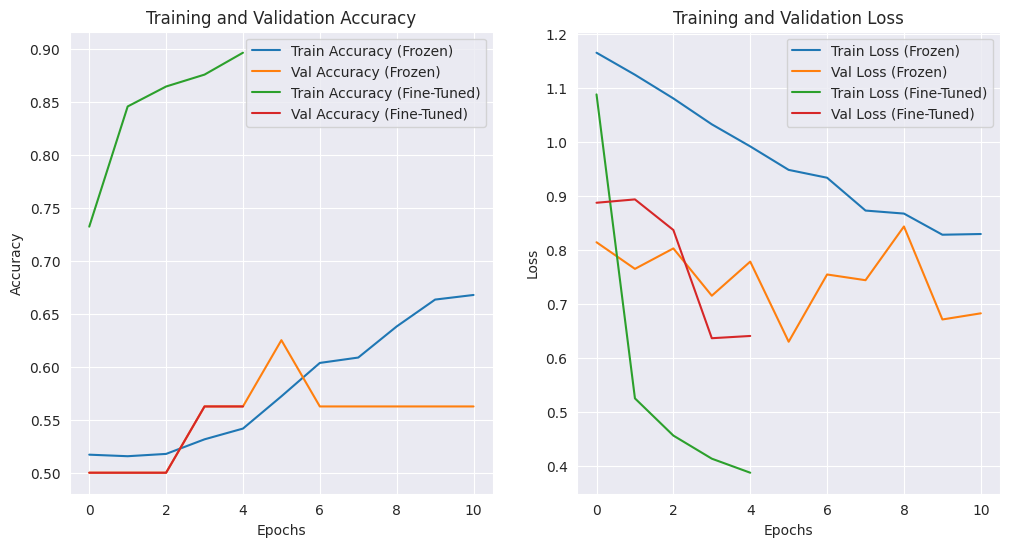

In [36]:
# Import necessary libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for pneumonia detection
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)  
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False



# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()
# Set up ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=30,         # Rotate images by up to 30 degrees
    width_shift_range=0.2,     # Shift horizontally by 20%
    height_shift_range=0.2,    # Shift vertically by 20%
    shear_range=0.2,           # Shear transformations
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True,      # Flip images horizontally
    fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

# Assuming your data is organized in directories
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset1/train',  # Path to training data
    target_size=(224, 224),  # Resize images to (224, 224)
    batch_size=64,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/dataset1/val',  # Path to validation data
    target_size=(224, 224),  # Resize images to (224, 224)
    batch_size=64,
    class_mode='binary'
)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Class weights to handle imbalanced dataset
class_weights = {0: 1.0, 1: 3.0}

history = model.fit(
    train_generator,  # Training data
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop, lr_scheduler],
    class_weight=class_weights


)

# Print final validation accuracy for frozen layers
final_val_accuracy_frozen = history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy (Frozen Layers): {final_val_accuracy_frozen:.2f}")

# Evaluate the model on the test dataset after training with frozen layers
test_generator = val_datagen.flow_from_directory(
    '/kaggle/input/dataset1/test',  # Path to test data
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

test_loss_frozen, test_accuracy_frozen = model.evaluate(test_generator, verbose=1)

# Unfreeze some of the base model layers for fine-tuning
for layer in base_model.layers[:50]:  # Keep the first 50 layers frozen
    layer.trainable = False
for layer in base_model.layers[50:]:  # Fine-tune the rest
    layer.trainable = True

# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training the model with fine-tuning
history_fine_tune = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop, lr_scheduler, checkpoint],
    class_weight=class_weights
)
# Print final validation accuracy for fine-tuned model
final_val_accuracy_fine_tuned = history_fine_tune.history['val_accuracy'][-1]
print(f"Final Validation Accuracy (Fine-Tuned): {final_val_accuracy_fine_tuned:.2f}")
# Evaluate the fine-tuned model on the test dataset
test_loss_fine_tune, test_accuracy_fine_tune = model.evaluate(test_generator, verbose=1)

# Print results
print("\nResults After ResNet50 (Frozen Layers):")
print("Test Accuracy:", test_accuracy_frozen)
print("Test Loss:", test_loss_frozen)

print("\nResults After ResNet50 (Fine-Tuned):")
print("Test Accuracy:", test_accuracy_fine_tune)
print("Test Loss:", test_loss_fine_tune)

# Save the fine-tuned model
model.save('/kaggle/working/pneumonia_detection_model_finetuned.h5')

# Plot training and validation accuracy and loss for both stages
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy (Frozen)')
plt.plot(history.history['val_accuracy'], label='Val Accuracy (Frozen)')
plt.plot(history_fine_tune.history['accuracy'], label='Train Accuracy (Fine-Tuned)')
plt.plot(history_fine_tune.history['val_accuracy'], label='Val Accuracy (Fine-Tuned)')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss (Frozen)')
plt.plot(history.history['val_loss'], label='Val Loss (Frozen)')
plt.plot(history_fine_tune.history['loss'], label='Train Loss (Fine-Tuned)')
plt.plot(history_fine_tune.history['val_loss'], label='Val Loss (Fine-Tuned)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


